# Active Learning

## pipeline process

### 1. 사용자 라벨링 데이터 획득 
### (사용자가 라벨링한 데이터 셋이 있다고 가정함, 예시로 COCO 데이터 중 특정 클래스 3개에 대한 데이터 30장을 추출하여 30장의 이미지파일과 1장의 라벨링 파일이 있다고 가정)

In [1]:
from modules.coco_extract import coco_cats

coco_cats()

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [2]:
from modules.coco_extract import extract_coco_images_and_json ,coco_cats, cat_names_to_id
""" 
사용자가 라벨 작업을 한 이미지 30장과 각각의 라벨 정보를 담고있는 .json 파일 1개가 있다고 가정
extract_coco_images_and_json : coco val2017 에서 person, dog, car 가있는 인덱스 30개 추출 , 해당하는 이미지 현재 디렉토리로 복사 & .json 파일 저장 
"""
cat_list = ["person","car","dog"]
ids = cat_names_to_id(cat_list)
json_path = "/home/tbelldev/workspace/autoLabeling/dataset/COCO_download/annotations/instances_val2017.json"
user_dataset_path = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_3/"
extract_file_name = cat_list[0]+"_"+cat_list[1]+"_"+cat_list[2]+".json"
entity = 50

extract_coco_images_and_json(json_path,ids,entity,user_dataset_path,extract_file_name)

loading annotations into memory...
Done (t=1.24s)
creating index...
index created!


### 2. 데이터 증강

In [3]:
from tool.augmentation import augmentator
user_dataset_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_3/"
output_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_3/augmented_data/"
task_type = "od"
''' 
    iter = 10 : 이미지 1장을 11장(원본 1장 + 증강 10장)으로 증강
    output_dir = 증강된 이미지 데이터와 label file이 저장될 위치
'''
augmentator(user_dataset_dir,output_dir,labeling_type = task_type,iter = 4)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 3. 학습

In [1]:
from modules.container_ctl import trainserver_start

dataset_path = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_3/augmented_data/"
labeling_type = "bbox"
project_name = "221026"
trainserver_start(dataset_path,labeling_type,project_name,device_id = 0)

<Container: cd473b49f0d6>

### 4. 모델 검증

In [2]:
from modules.model_validation import model_validation
from modules.container_ctl import get_container_list

model_repo = "/home/tbelldev/workspace/autoLabeling/api_test/model_repo/"
current_prj_name = "221026"

weight_path = model_validation(model_repo,current_prj_name)
print(weight_path)

/home/tbelldev/workspace/autoLabeling/api_test/model_repo/221026_1/model_final.pth


### 5. 모델 변환

In [15]:
from tool.model_export import make_yaml, configure_model_dir 
from glob import glob

task_type = "od"
user_dataset_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample_3/"
sample_image = [i for i in glob(user_dataset_dir+"/*.jpg")][2]

# cfg_path = make_yaml(task_type,weight_path)
cfg_path = [i for i in glob("/".join(weight_path.split("/")[:-1])+"/*.yaml")][0]
configure_model_dir(task_type=task_type,cfg_file=cfg_path,sample_image=sample_image,output_dir_name = weight_path.split("/")[-2])

[W init.cpp:759] Warning: Use _jit_set_fusion_strategy, bailout depth is deprecated. Setting to (STATIC, 1) (function operator())


[10/26 08:26:51 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

/home/tbelldev/workspace/detectron2/detectron2/detectron2/structures/image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/home/tbelldev/anaconda3/envs/autolabeling/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tbelldev/workspace/detectron2/detectron2/detectron2/structures/boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be t

[10/26 08:27:00 detectron2]: Inputs schema: TupleSchema(schemas=[ListSchema(schemas=[DictSchema(schemas=[IdentitySchema()], sizes=[1], keys=['image'])], sizes=[1])], sizes=[1])
[10/26 08:27:00 detectron2]: Outputs schema: ListSchema(schemas=[DictSchema(schemas=[InstancesSchema(schemas=[TensorWrapSchema(class_name='detectron2.structures.Boxes'), IdentitySchema(), IdentitySchema()], sizes=[1, 1, 1], keys=['pred_boxes', 'pred_classes', 'scores'])], sizes=[4], keys=['instances'])], sizes=[4])
[10/26 08:27:00 detectron2]: Success.


### 6. 배포

In [32]:
from modules.container_ctl import get_port_usage , inference_server_start, get_container_list
print(get_port_usage())

{'inference_server_221026': '8003', 'tritonserver': '8000'}


In [17]:
model_path = "/home/tbelldev/workspace/autoLabeling/api_test/models"
port = 8003
# prj_name = weight_path.split("/")[-2]
project_name = "221026"
inference_server_start(model_path,port,project_name,device_id = 0)

<Container: cee7bbe2c319>

In [24]:
import inference
import cv2
import numpy as np
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt


image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco/images/val/000000263594.jpg"

image = cv2.imread(image_path)

result_box = inference.inference_triton(image_path,model_name = "221026_1",port = 8003,label_type = "bbox")

speed: 0.047055721282958984


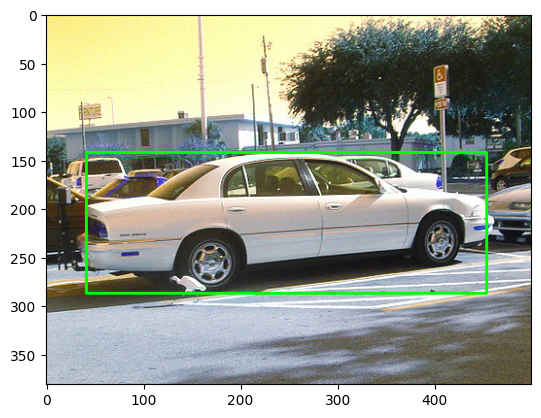

score :  94.56636905670166
class :  1


In [31]:
idx = 2
box = result_box['bboxes__0'][idx].tolist()
bbox = list(map(int, box))
image_copy = image.copy()
image_with_box = cv2.rectangle(image_copy,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0),2)
plt.imshow(image_with_box)
plt.show()

print("score : ",result_box['scores__2'][idx]*100)
print("class : ",result_box['classes__1'][idx])